<a href="https://colab.research.google.com/github/InowaR/colab/blob/main/ICP_scans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

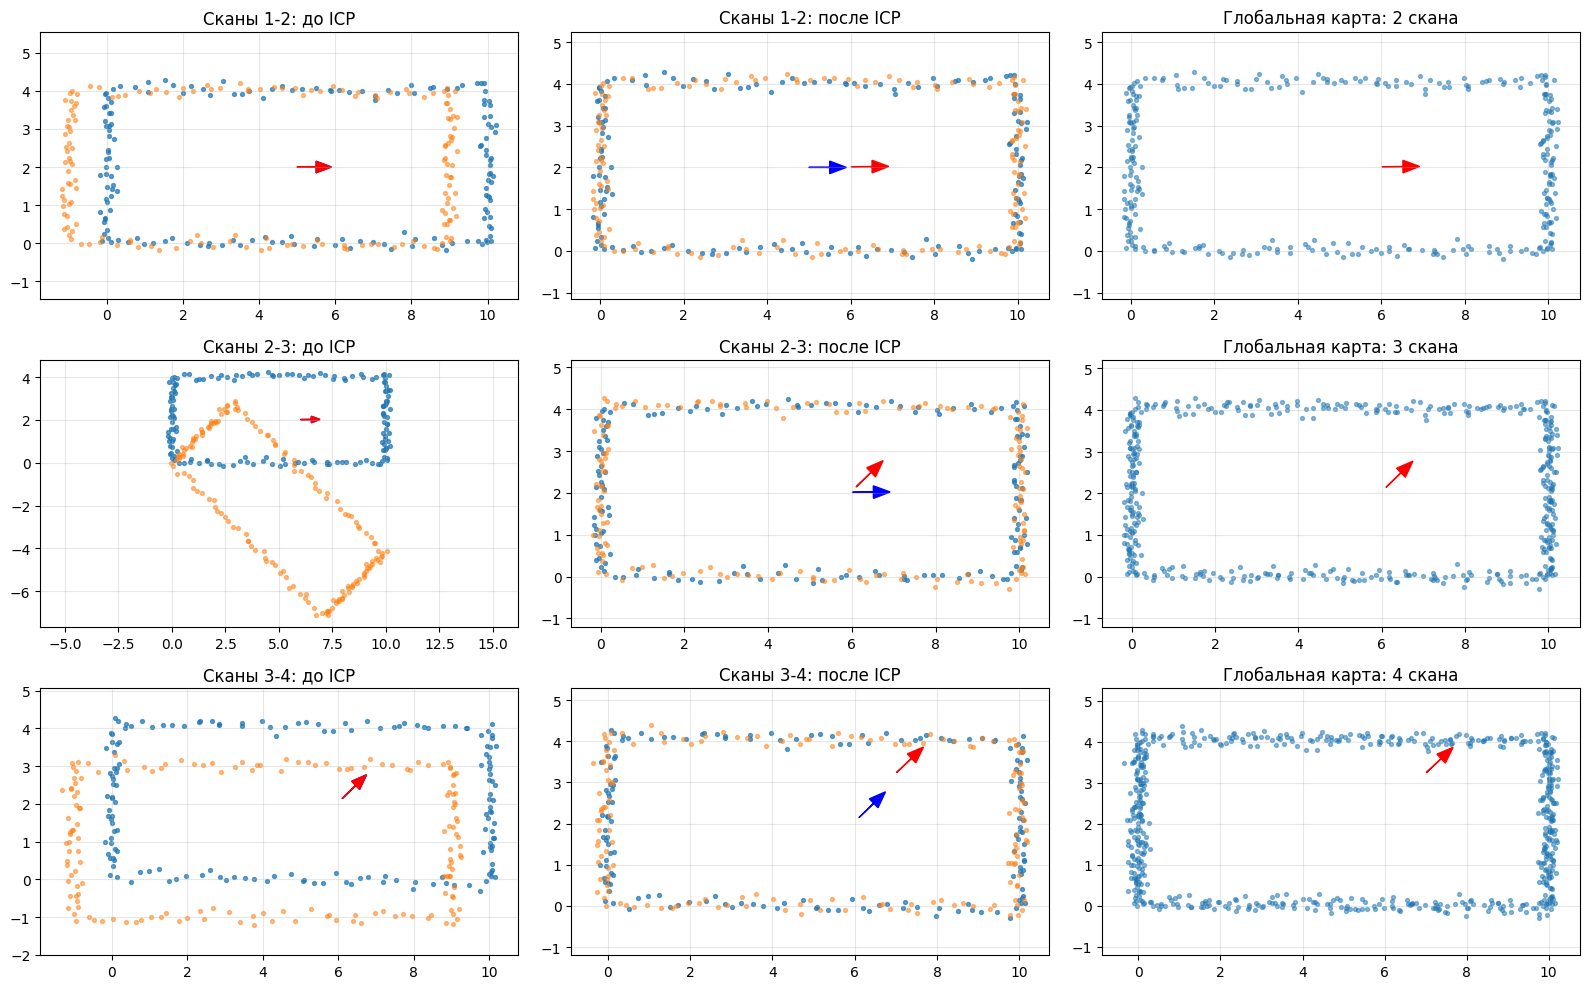

Робот 1: x=5.00, y=2.00, угол=0.0°
Робот 2: x=6.02, y=2.02, угол=0.4°
Робот 3: x=6.10, y=2.14, угол=44.2°
Робот 4: x=7.02, y=3.24, угол=43.4°


In [106]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree

NUM_POINTS = 40
NUM_OBSTACLES = 0
NOISE_LEVEL = 0.1
ITERS = 40

def icp(src, tgt):
    tree = KDTree(tgt)
    R, t = np.eye(2), np.zeros(2)
    for _ in range(ITERS):
        tr = src @ R.T + t
        idx = tree.query(tr)[1]
        src_m, tgt_m = tr.mean(0), tgt[idx].mean(0)
        H = (tr - src_m).T @ (tgt[idx] - tgt_m)
        U, _, Vt = np.linalg.svd(H)
        R_new = Vt.T @ U.T
        t_new = tgt_m - R_new @ src_m
        R, t = R_new @ R, R_new @ t + t_new
    return [t[0], t[1], np.arctan2(R[1,0], R[0,0])]

def create_scans():
    v = np.array([[0,0],[0,4],[10,4],[10,0]])
    points = np.vstack([v[i]+t*(v[(i+1)%4]-v[i])
                       for i in range(4) for t in np.linspace(0,1,NUM_POINTS)])[:-1]

    angles = [0, 0, np.radians(45), 0]
    translations = [(0, 0), (1, 0), (0, 0), (1, 1)]
    scans = []

    for i, angle in enumerate(angles):
        R = [[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]]
        scan_raw = points @ R
        scan_raw = scan_raw - translations[i]
        scan_noisy = scan_raw + np.random.randn(*scan_raw.shape) * NOISE_LEVEL
        obstacles = np.random.uniform(1, 4, (NUM_OBSTACLES, 2)) @ R
        obstacles = obstacles - translations[i]
        scan = np.vstack([scan_noisy, obstacles])
        scans.append(scan)

    return scans

def process_sequentially(scans):
    aligned = [scans[0].copy()]
    robots = [(5, 2, 0)]

    for i in range(1, len(scans)):
        dx, dy, da = icp(aligned[-1], scans[i])
        R = [[np.cos(da), -np.sin(da)], [np.sin(da), np.cos(da)]]
        aligned_scan = (scans[i] - [dx, dy]) @ R
        aligned.append(aligned_scan)

        prev_robot = robots[-1]
        new_robot = (prev_robot[0] - dx, prev_robot[1] - dy, prev_robot[2] - da)
        robots.append(new_robot)

    return aligned, robots

def draw_robot(ax, x, y, angle, color):
    ax.arrow(x, y, 0.5*np.cos(angle), 0.5*np.sin(angle),
             head_width=0.3, head_length=0.4, fc=color, ec=color)

def plot_scan_pair(ax, scan1, scan2, robot1, robot2, title, colors=('b', 'r')):
    ax.scatter(scan1[:,0], scan1[:,1], s=8, alpha=0.7)
    ax.scatter(scan2[:,0], scan2[:,1], s=8, alpha=0.5)
    draw_robot(ax, robot1[0], robot1[1], robot1[2], colors[0])
    draw_robot(ax, robot2[0], robot2[1], robot2[2], colors[1])
    ax.set_title(title)
    ax.axis('equal')
    ax.grid(True, alpha=0.3)

def plot_global_map(ax, all_scans, robot, title):
    combined = np.vstack(all_scans)
    ax.scatter(combined[:,0], combined[:,1], s=8, alpha=0.5)
    draw_robot(ax, robot[0], robot[1], robot[2], 'r')
    ax.set_title(title)
    ax.axis('equal')
    ax.grid(True, alpha=0.3)

def plot_results(scans, aligned, robots):
    fig = plt.figure(figsize=(16, 10))

    rows = len(scans) - 1
    gs = fig.add_gridspec(rows, 3)

    plot_scan_pair(fig.add_subplot(gs[0, 0]),
                   scans[0], scans[1],
                   robots[0], robots[0],
                   'Сканы 1-2: до ICP')

    plot_scan_pair(fig.add_subplot(gs[0, 1]),
                   scans[0], aligned[1],
                   robots[0], robots[1],
                   'Сканы 1-2: после ICP')

    plot_global_map(fig.add_subplot(gs[0, 2]),
                    [scans[0], aligned[1]],
                    robots[1],
                    'Глобальная карта: 2 скана')

    for i in range(1, rows):
        plot_scan_pair(fig.add_subplot(gs[i, 0]),
                       aligned[i], scans[i+1],
                       robots[i], robots[i],
                       f'Сканы {i+1}-{i+2}: до ICP')

        plot_scan_pair(fig.add_subplot(gs[i, 1]),
                       aligned[i], aligned[i+1],
                       robots[i], robots[i+1],
                       f'Сканы {i+1}-{i+2}: после ICP')

        plot_global_map(fig.add_subplot(gs[i, 2]),
                        [scans[0]] + aligned[1:i+2],
                        robots[i+1],
                        f'Глобальная карта: {i+2} скана')

    plt.tight_layout()
    plt.show()

scans = create_scans()
aligned, robots = process_sequentially(scans)
plot_results(scans, aligned, robots)

for i, robot in enumerate(robots):
    print(f"Робот {i+1}: x={robot[0]:.2f}, y={robot[1]:.2f}, угол={np.degrees(robot[2]):.1f}°")